### Import Libraries

In [5]:
pip install datasets

In [38]:
import os
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from collections import Counter

### Data Analysis

#### Data Loading

In [7]:
ds = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [9]:
print(ds)

# master label
# 0 cardboard
# 1 glass
# 2 metal
# 3 paper
# 4 plastic

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})


In [32]:
sample_img = ds['train'][2000]['image']
sample_label = ds['train'][2000]['label']

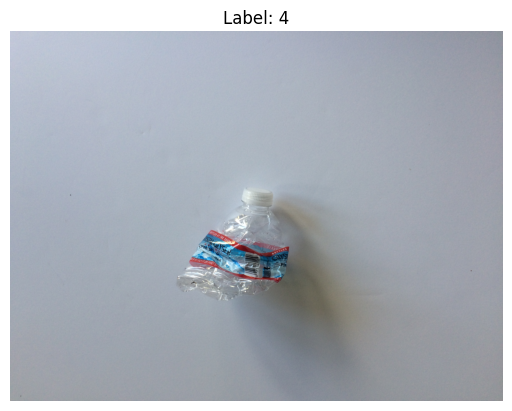

In [33]:
plt.imshow(sample_img)
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### Data Validation

In [39]:
labels = [data['label'] for data in ds['train']]

In [41]:
label_count = Counter(labels)
print(label_count)

Counter({3: 1188, 1: 1002, 4: 964, 2: 820, 0: 806, 5: 274})


In [48]:
def validate_img(ds):
    count=0
    for i in ds['train']:
        try:
            img = i['image'] #load image to check
            count+=1
        except Exception as e:
            print(f"total number of corrupt images:{e}")
    print(f"total number of valid iamges:{count}")


validate_img(ds)
# o/p
# total number of valid iamges:5054

total number of valid iamges:5054
